## Covid19 Analysis & Forecast
##### by Khairul Omar

### 1. Import data

In [1]:
# Import libraries
import pandas as pd
pd.options.display.max_rows = 50
import numpy as np
import math
import json
import requests
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pm_fitting import *
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

In [2]:
# # Multiple downloads from John Hopkins Hospital database
# start  = pd.to_datetime(f'20200122', format='%Y%m%d')
# oneday = pd.Timedelta(1, unit='days')
# end    = pd.to_datetime(f'20200315', format='%Y%m%d')
# for d in range((end - start).days+1):
#     date = start + oneday * d
#     day, month, year = str(date)[8:10], str(date)[5:7], str(date)[:4]
#     url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{month}-{day}-{year}.csv'
#     df = pd.read_csv(url)
#     df.to_csv(f'csv/{month}-{day}-{year}.csv')

In [3]:
# One-day download from John Hopkins Hospital database
day = 21
month = 3
date  = pd.to_datetime(f"20200{month}{0 if day<10 else ''}{day}", format='%Y%m%d')
day0, month0, year0 = str(date)[8:10], str(date)[5:7], str(date)[:4]
url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{month0}-{day0}-{year0}.csv'
zero = 0 if day < 10 else ''
df = pd.read_csv(url)
df.to_csv(f'csv/0{month}-{zero}{day}-2020.csv')

In [4]:
path = 'csv/'
fileList = os.listdir(path)
df = pd.DataFrame()
for file in fileList:
    if file.endswith('.csv'):
        df0 = pd.read_csv(f'{path}{file}')
        df0.columns = map(str.lower, df0.columns)
        df0 = df0.rename(columns={'country/region':'country'})
        df0 = df0.rename(columns={'province/state':'state'})
        df0 = df0.rename(columns={'last update':'updated'})
        df0 = df0[['updated','country','state','confirmed','deaths','recovered']]
        df0.updated = pd.to_datetime(df0.updated)
        df0.state = df0.state.fillna('')
        df0['date'] = pd.to_datetime(f'{file[6:10]}{file[0:2]}{file[3:5]}', format='%Y%m%d')
        for col in ['confirmed','deaths','recovered']:
            df0[col] = df0[col].fillna(0)
            df0[col] = df0[col].astype(int)
        df = pd.concat([df, df0])
#df['update_date'] = df.updated.apply(lambda row: pd.to_datetime(f'{str(row)[0:4]}{str(row)[5:7]}{str(row)[8:10]}', format='%Y%m%d'))

df0 = df.copy() # temp

In [5]:
df = df0.copy()

# Geo clean-up mapping dictionary
geo = json.load(open('geo.json'))
df.country = df.country.apply(lambda row: geo['countries'][row] if row in list(geo['countries'].keys()) else row)
df['temp'] = ''
for i in range(len(df)):
    state = df.iloc[i].state
    country = df.iloc[i].country
    if state in ['Channel Islands', 'Gibraltar', 'Cayman Islands',
                 'Faroe Islands', 'French Polynesia', 'Saint Barthelemy', 'St Martin']:
        df.iloc[i, df.columns.get_loc('country')] = df.iloc[i, df.columns.get_loc('state')]
    elif (state == country) | (state == 'None') | (state == 'UK'):
        df.iloc[i, df.columns.get_loc('state')] = country
    elif state.find('Princess') > 0:
        if country != 'Cruise Ship':
            df.iloc[i, df.columns.get_loc('state')] = f'Cruise {country}'
        else:
            df.iloc[i, df.columns.get_loc('state')] = 'Cruise Ship'
    elif country == 'United States':
        if state == 'Washington, D.C.':
            s = 'DC'
        if state == "Virgin Islands, U.S.":
            s = 'VI'
        elif state.find(', ') > 0:
            s = state[state.find(', ')+2:state.find(', ')+4]
        elif state in list(geo['us_states'].keys()):
            s = geo['us_states'][state]
        else:
            s = state
        df.iloc[i, df.columns.get_loc('temp')] = s
    elif country == 'Canada':
        if state.find('Princess') > 0:
            s = 'Cruise Ship'      
        elif state.find(', ') > 0:
            ca = {'Edmonton, Alberta':'Alberta', 'Calgary, Alberta':'Alberta',
                  'London, ON':'Ontario', 'Toronto, ON':'Ontario', ' Montreal, QC':'Quebec'}
            s = ca[state]
        else:
            s = state
        df.iloc[i, df.columns.get_loc('temp')] = s

df['state'] = df.apply(lambda row: row['temp'] if row['temp']!='' else (row['state'] if row['state']!='' else row['country']), axis=1)
df.drop('temp', axis=1, inplace=True)

df = pd.pivot_table(df, values=['confirmed','deaths','recovered'], index=['date','updated','country','state'], columns=None, aggfunc='sum')
df = df.rename(columns={'confirmed':'confirmed_raw'})
df = df.reset_index()
dftemp = pd.DataFrame()
for state in df.state.unique():
    dfstate = df[df.state==state].copy()
    dfstate = dfstate.sort_index(ascending=False)
    dfstate['confirmed'] = dfstate.confirmed_raw
    # Replace raw with average between 2 dates due to incomplete data due to cut-off reporting time
    # e.g. if new cases suddenly drop by 90% in one day, most likely it's due to incomplete data
    for i in range(1,len(dfstate.index)-1):
        ratio = 1/2 # smoothing average ratio
        if dfstate.iloc[i+1].confirmed_raw / dfstate.iloc[i].confirmed_raw > 0.9:
            dfstate.iloc[i, dfstate.columns.get_loc('confirmed')] = int(dfstate.iloc[i+1].confirmed_raw * ratio
                                                                        + dfstate.iloc[i-1].confirmed_raw * (1-ratio))
    for col in ['confirmed','deaths','recovered']:
        colname = f'new_{col}'
        dfstate[colname] = dfstate[col].diff(-1)
        dfstate[colname] = dfstate[colname].fillna(dfstate[col])
        dfstate[colname] = dfstate[colname].astype('int')
    dftemp =  pd.concat([dftemp, dfstate])
df = dftemp.sort_values(['date','new_confirmed'], ascending=False)
allcols = ['date','updated', 'country', 'state', 'confirmed', 'deaths', 'recovered', 'new_confirmed', 'new_deaths', 'new_recovered']
df = df[allcols]
df = df.reset_index(drop=True)

In [6]:
# Country-level data
df1 = pd.pivot_table(df, values=df.columns[4:], index=['date','country'], columns=None, aggfunc='sum')
df1 = df1.reset_index()
df1.shape
df1 = df1.sort_values(['date','confirmed'], ascending=False)
df1 = df1[['date','country'] + allcols[-6:]]
df1 = df1.set_index('date')

### 2. Analyse latest data


Top 20 countries by total cases as of 21/3/2020


,country,confirmed,deaths,recovered,new_confirmed,new_deaths,new_recovered
date,,,,,,,
2020-03-21,China,81305,3259,71857,63,6,591
2020-03-21,Italy,53578,4825,6072,6557,793,1632
2020-03-21,United States,25493,307,171,6255,63,24
2020-03-21,Spain,25374,1375,2125,4964,332,537
2020-03-21,Germany,22213,84,233,2365,17,53
2020-03-21,Iran,20610,1556,7635,1102,123,890
2020-03-21,France,14393,562,12,1684,112,0
2020-03-21,South Korea,8799,102,1540,117,8,0
2020-03-21,Switzerland,6575,75,15,1281,21,0



New confirmed cases from 1/2/2020 to 21/3/2020


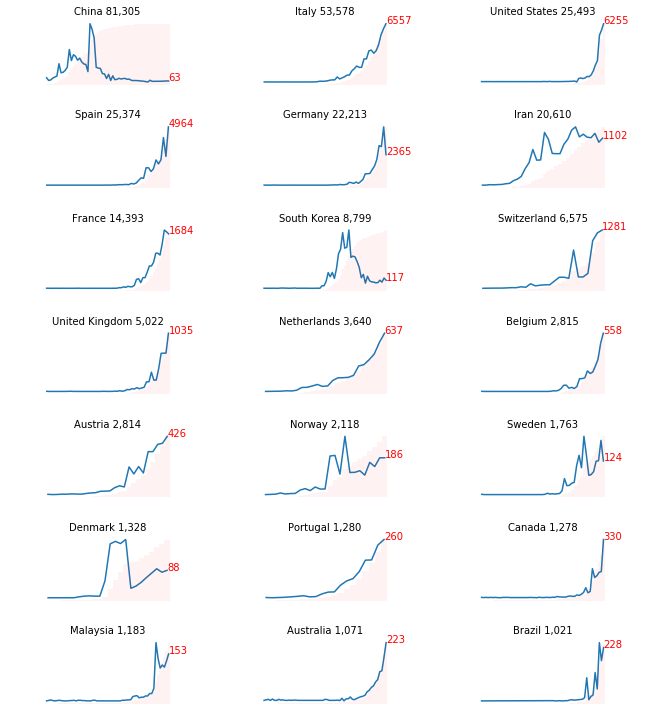

In [7]:
# Display one day data
day = day
month = month
date = pd.to_datetime(f"20200{month}{0 if day<10 else ''}{day}", format='%Y%m%d')
oneday = pd.Timedelta(1, unit='days')

top = 20
latest = df1.loc[date]
print(f'\nTop {top} countries by total cases as of {date.day}/{date.month}/2020')
display(latest[:top])

# Select diplay data
until = date
data = df1[until:]

# Plot data
print(f'\nNew confirmed cases from 1/2/2020 to {date.day}/{date.month}/2020')
countries = list(latest[:top+1].country)
# countries.remove('Cruise Ship')
fig, axes = plt.subplots(ncols=3, nrows=round(len(countries)/3), figsize=(9,10), constrained_layout=True)
for i, ax in zip(range(len(countries)), axes.flat):
    cdata = data[data.country==countries[i]]
    ax.plot(cdata.new_confirmed)
    ax.text(until, cdata.loc[until].new_confirmed, cdata.loc[until].new_confirmed, color='red')
    ax2 = ax.twinx()
    ax2.bar(cdata.index, cdata.confirmed, color='red', alpha=0.05, width=1)
    ax.set_title(f'{countries[i]} {format(cdata.loc[until].confirmed, ",")}', fontsize=10)
    ax.axis('off')
    ax2.axis('off')
plt.show()

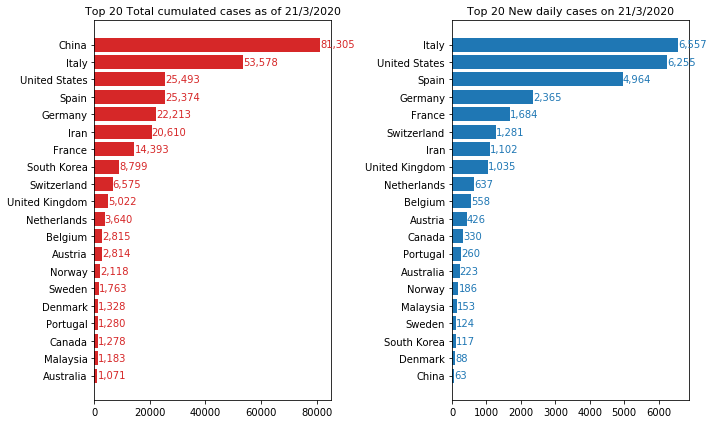

In [8]:
cols = ['confirmed','new_confirmed']
titles = ['Total cumulated cases as of ','New daily cases on ']
colors = ['C3','C0']
fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=2)
for i, ax in zip(range(len(cols)), axes.flat):
    data = latest[:top][['country',cols[i]]].reset_index(drop=True).set_index('country').sort_values(by=cols[i])
    ax.barh(data.index, data[cols[i]], color=colors[i])
    ax.set_title(f'Top {top} {titles[i]}{date.day}/{date.month}/2020', fontsize='11')
    for n, v in enumerate(data[cols[i]]):
        ax.text(v, n, format(v, ","), va='center', fontsize=10, color=colors[i])
plt.tight_layout()
plt.show()

In [9]:
df2 = df1[['country', 'confirmed', 'new_confirmed']].sort_index().reset_index()
dftemp = pd.DataFrame()
for country in df2.country.unique():
    dfc = df2[df2.country==country].copy().reset_index(drop=True)
    dfc['growth'] = 0
    dfc['new_growth'] = 0
    for i in range(1,len(dfc.index)):
        for newcol in ['growth', 'new_growth']:
            oldcol = 'confirmed' if newcol == 'growth' else 'new_confirmed'
            dfc.iloc[i, dfc.columns.get_loc(newcol)] = 0 if dfc.iloc[i-1][oldcol] == 0 else round(dfc.iloc[i][oldcol]/dfc.iloc[i-1][oldcol]-1,2)
    dftemp =  pd.concat([dftemp, dfc])
df2 = dftemp[dftemp.confirmed > 50] # ignore cases below 50
df2 = df2.reset_index(drop=True)

In [10]:
# print(f'\nDay-to-day % growth of new confirmed cases from 1/2/2020 to {date.day}/{date.month}/2020')
# countries = list(latest[:18].country)
# fig, axes = plt.subplots(ncols=3, nrows=round(len(countries)/3), figsize=(8.5,10), constrained_layout=True)
# col = ['growth']
# for i, ax in zip(range(len(countries)), axes.flat):
#     data = df2[df2.country==countries[i]].reset_index(drop=True)
#     ax.plot(data[col].rolling(window=2).mean())
#     ax.hlines(0,data.index.min(),data.index.max(), alpha=0.1)
#     ax.set_ylim(-0.1, 0.8)
#     ax.set_title(countries[i], fontsize=10)
# plt.show()

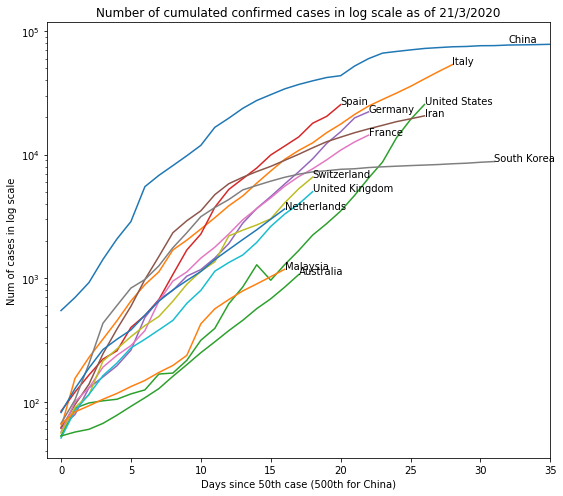

In [11]:
fig, ax = plt.subplots(figsize=(8,7))
for country in list(latest[:11].country) + ['Malaysia','Australia']:
    data = df2.loc[(df2.country==country) & (df2.confirmed > 0), 'confirmed'].reset_index(drop=True)
#     scaler = MinMaxScaler()
#     data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    plt.plot(data, label=country)
    xmax = 35
    plt.text(xmax-3 if country=='China' else data.index.max(), data.max(), country)
plt.yscale('log')
ax.set_title(f'Number of cumulated confirmed cases in log scale as of {date.day}/{date.month}/2020')
ax.set_xlim(-1, xmax)
ax.set_ylabel('Num of cases in log scale')
ax.set_xlabel('Days since 50th case (500th for China)')
plt.tight_layout()
plt.savefig('img/cumulated_by_country', pad_inches=0)
plt.show()

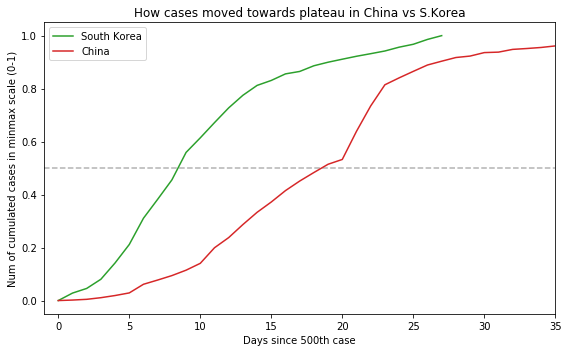

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
color = ['C2','C3']
for i, country in enumerate(['South Korea','China']):
    data = df2.loc[(df2.country==country) & (df2.confirmed > 500), 'confirmed'].reset_index(drop=True)
    scaler = MinMaxScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    plt.plot(data, label=country, c=color[i])
xmax = 35
plt.hlines(0.5,-1, xmax, linestyle='dashed', alpha=0.3)
#plt.yscale('log')
ax.set_title('How cases moved towards plateau in China vs S.Korea')
ax.set_xlim(-1, xmax)
ax.set_ylabel('Num of cumulated cases in minmax scale (0-1)')
ax.set_xlabel('Days since 500th case')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('img/plateau_china_vs_korea', pad_inches=0)
plt.show()

### Forecasting

In [13]:
# Generalised logistic function (Richard's curve)
def richards(x, A, K, C, Q, B, v):
    y = A + (K-A) / ((C + (Q * np.exp(-1 * B * x))) ** (1/v))
    return y

# Fit to Richard's curve model
def fit_richards(country, rolling=1, fit_start=None, fit_end=None, days=110, df2=df2):

    # All dates in raw Actuals
    dates = df2.loc[df2.country==country].reset_index(drop=True).date
    # All raw Actuals
    actual0    = df2.loc[df2.country==country, 'confirmed'].reset_index(drop=True)
    actual0new = df2.loc[df2.country==country, 'new_confirmed'].reset_index(drop=True)

    # Limit Actual data period for model fit
    oneday = pd.Timedelta(1, unit='days')
    fit_start   = pd.to_datetime(fit_start, format='%Y%m%d')
    fit_end     = pd.to_datetime(fit_end, format='%Y%m%d')
    index_start = list(dates[dates==fit_start].index)[0] if fit_start != None else None
    index_end   = list(dates[dates==fit_end+oneday].index)[0] if fit_end != None else None
    actual1 = actual0.iloc[index_start:index_end]

    # Data for model fit input after rolling average
    dropna = range(actual1.index.min(),actual1.index.min()+(rolling-1))
    actual2 = actual1.rolling(window=rolling).mean().drop(dropna) if rolling > 1 else actual1
    xdata = np.array(range(rolling,len(actual2)+rolling)) # TO BE CHECKED
    ydata = np.array(actual2.values)

    # Fit model
    popt, pcov = curve_fit(richards, xdata, ydata, maxfev=3000)
    A, K, C, Q, B, v = popt
    hyperparams = [A, K, C, Q, B, v]

    xdata2 = np.array(range(days))
    index = range(actual2.index.min(), days+actual2.index.min()) # TO BE FIXED !!!
    predict = pd.DataFrame(richards(xdata2, A, K, C, Q, B, v), columns=['predict'], index=index)
    predict = predict.iloc[:,0]
    
    return hyperparams, dates, actual0, actual2, predict, actual0new

# Fit to curve and plot prediction
def predict_plot(country, rolling=1, fit_start=None, fit_end=None, days=110, showzero=True, showpeak=True, df2=df2):

    hyperparams, dates, actual0, actual2, predict, actual0new = fit_richards(country, rolling, fit_start, fit_end, days, df2)
        
    # Find dates for plot labels
    # Latest available date in raw Actual
    latestdate = dates.iloc[-1]
    # Calculate difference between predicted days to find plateau
    predict = predict if predict.isna().sum() > 0 else predict.astype('int')
    newcase0 = predict.diff().drop(predict.index.min())
    newcase1 = newcase0.iloc[actual2.index.max():] # exclude if zero happens during Actual period
    # If prediction doesn't coverge to plateau, don't show
    if np.isnan(newcase1[newcase1==0].index.min()):
        showzero = False
    # If prediction converges to plateau:
    else:
        # Day when difference between days equal to zero
        zerocase = newcase1[newcase1==0].index.min()
        to_go_weeks = math.ceil((zerocase - actual2.index.max())/7)
        oneday = pd.Timedelta(1, unit='days')
        zerodate = latestdate + oneday * to_go_weeks * 7
        # Day when daily peak is reached
    # If turning point has happened during actuals, don't show
    if newcase0.max() > newcase1.max():
        showpeak = False
    else:
        turning_point = newcase0[newcase0==newcase0.max()].index[0]
        to_peak_weeks = math.ceil((turning_point - actual2.index.max())/7)
                
    fig, ax = plt.subplots(figsize=(10,5), ncols=2, nrows=1)
    mdict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    
    # Plot prediction
    ax[0].plot(predict,  ls='dashed', c='#ff7f0e', label='Forecast')
    ax[1].plot(newcase0, ls='dashed', c='#ff7f0e', label='Forecast')
    
    # Plot actual
    ax[0].plot(actual0, c='C0', label='Actual to date')
    ax[0].scatter(actual0.index[-1], int(actual0.iloc[-1]), c='C0')
    ax[0].text(actual0.index[-1], actual0.iloc[-1], f'{latestdate.day} {mdict[latestdate.month]}\n{format(int(actual0.iloc[-1]), ",")} cases', va='top')
    ax[1].plot(actual0new, c='C0', label='Actual daily')
    
    # Plot actual moving average
    if rolling > 1:
        ax[0].plot(actual2, ls=':', label=f'Act {rolling}-day moving avg')

    # Plot prediction end points
    if showzero==True:
        ax[0].scatter(zerocase, predict.max(), c='C1')      
        predictmax = int(math.ceil(predict.max()/100.0))*100 if predict.max() > actual2.iloc[-1] else int(math.ceil(actual0.iloc[-1]/100.0))*100
        ax[0].text(zerocase, predictmax, f"{zerodate.day} {mdict[zerodate.month]}\n{format(predictmax, ',')} cases\nin {to_go_weeks} week{'s' if to_go_weeks>1 else ''}", va='top')
    if showpeak==True:
        ax[1].scatter(turning_point, newcase0.max(), c='C1')
        ax[1].text(turning_point, newcase0.max(), f"In {to_peak_weeks} week{'s' if to_peak_weeks>1 else ''}", va='bottom')
    
    # Plot titles and axis
    ax[0].set_title(f'{country.upper()}\nTotal cumulated cases')
    ax[0].set_ylabel('Num of cumulative cases')
    ax[0].set_xlabel('Days since 50th case')
    ax[1].set_title(f'{country.upper()}\nNew daily cases')
    ax[1].set_ylabel('Num of new daily cases')
    ax[1].set_xlabel('Days since 50th case')
    
    ax[0].legend(loc='center right')
    ax[1].legend(loc='center right')
    
    plt.tight_layout()
    plt.savefig(f"img/forecast_{country.replace(' ','_')}", pad_inches=0)
    plt.show()
    
    A, K, C, Q, B, v = hyperparams
    print(f'{country} A={int(A)}, K={int(K)}, C={round(C,4)}, Q={round(Q,4)}, B={round(B,4)}, v={round(v,4)}')

In [14]:
# dates, actual0, actual2, predict, actual0new = fit_richards('United Kingdom', rolling=1, fit_start='20200311', fit_end=None, days=50, df2=df2)

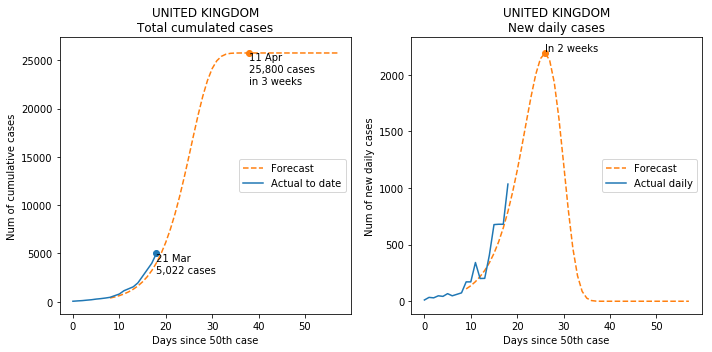

United Kingdom A=25759, K=-3543, C=1.0044, Q=0.0006, B=-0.2357, v=0.0346


In [15]:
predict_plot('United Kingdom', days=50, fit_start='20200311', fit_end='20200320')

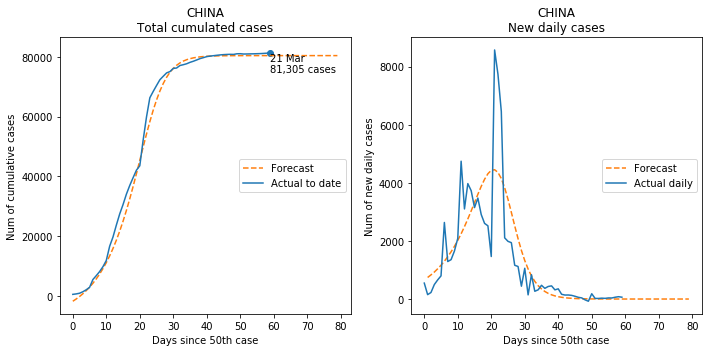

China A=-7932, K=6507, C=0.0083, Q=9.4168, B=0.3, v=2.6442


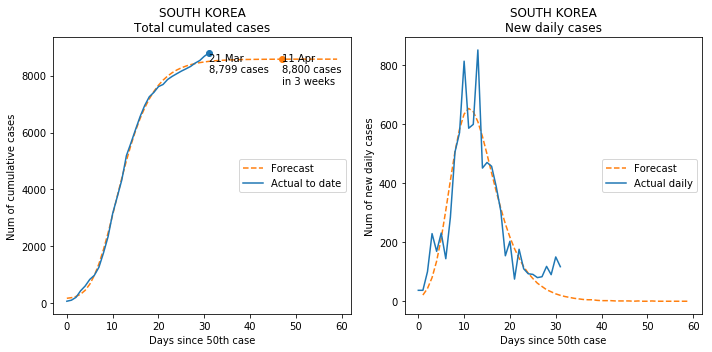

South Korea A=155, K=537, C=0.5813, Q=1.163, B=0.2292, v=0.1753


In [16]:
predict_plot('China', days=80, showzero=False)
predict_plot('South Korea', rolling=0, days=60)

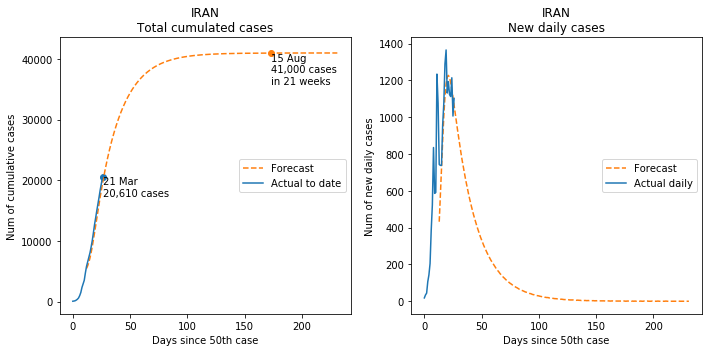

Iran A=41001, K=2969, C=1.393, Q=0.3751, B=-0.4109, v=8.3574


In [17]:
predict_plot('Iran', days=220, fit_start='20200307')

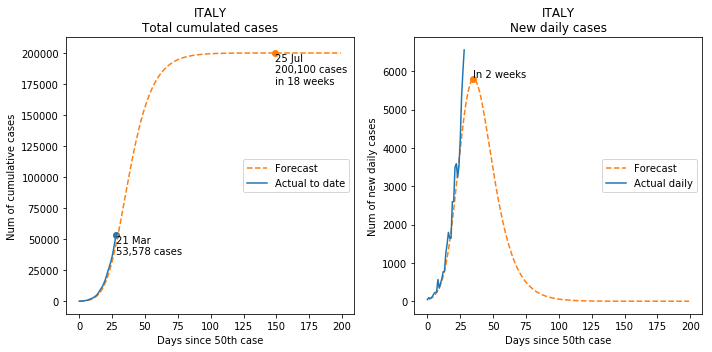

Italy A=-94, K=2952, C=0.3288, Q=1.9149, B=0.0891, v=0.2658


In [18]:
predict_plot('Italy', days=200, fit_end='20200319')

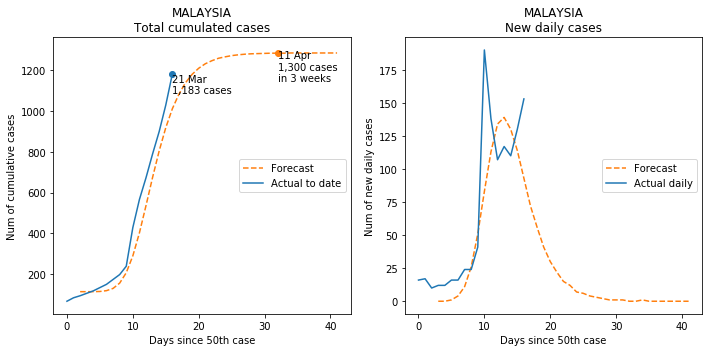

Malaysia A=113, K=199, C=0.6101, Q=4.4736, B=0.3538, v=0.1894


In [19]:
predict_plot('Malaysia', days=40, fit_start='20200307',fit_end='20200320')

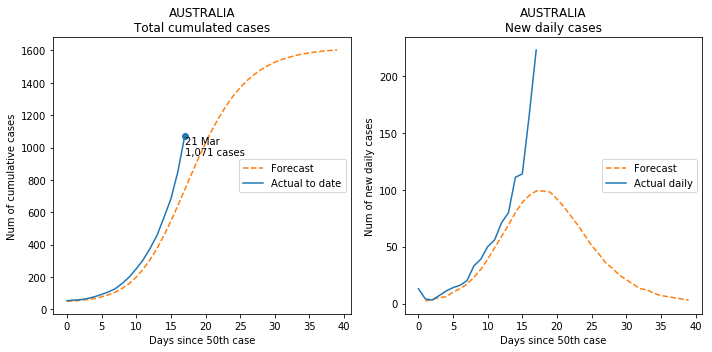

Australia A=45, K=89, C=0.1255, Q=3.2743, B=0.221, v=0.5829


In [20]:
predict_plot('Australia', days=40, fit_end='20200317', showpeak=False)

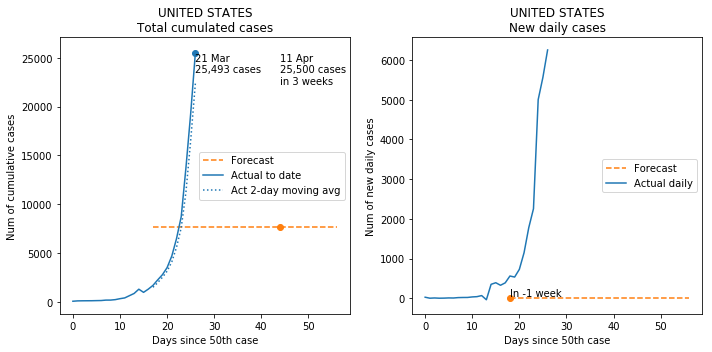

United States A=7640, K=196, C=1.4423, Q=4.0428, B=0.038, v=0.0217


In [21]:
#predict_plot('United States', showzero=False, fit_end='20200316')
#predict_plot('United States', rolling=2, fit_start='20200310', fit_end='20200320', days=40)
predict_plot('United States', rolling=2, fit_start='20200311', days=40)

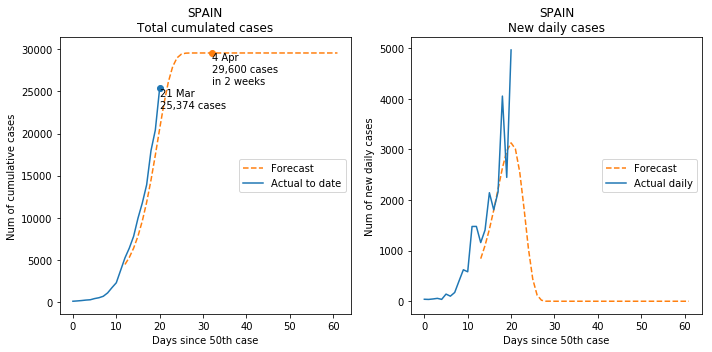

Spain A=29562, K=-44944, C=1.0019, Q=0.0002, B=-0.3101, v=0.0019


In [22]:
#predict_plot('Spain', days=200, fit_end='20200316')
predict_plot('Spain', days=50, fit_start='20200313', fit_end='20200320')

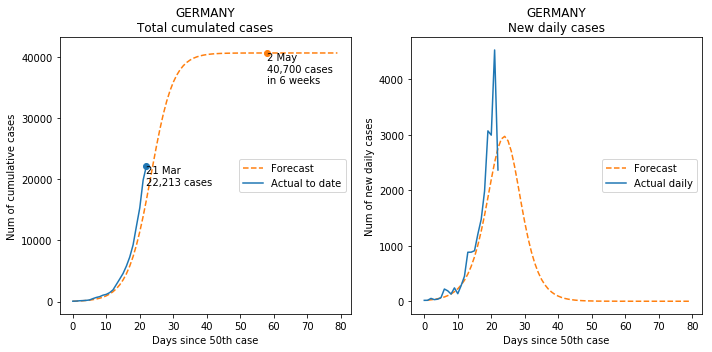

Germany A=-8, K=167, C=0.0023, Q=3.1241, B=0.3035, v=1.1152


In [23]:
predict_plot('Germany', rolling=1, days=80, fit_end='20200317', showpeak=False)

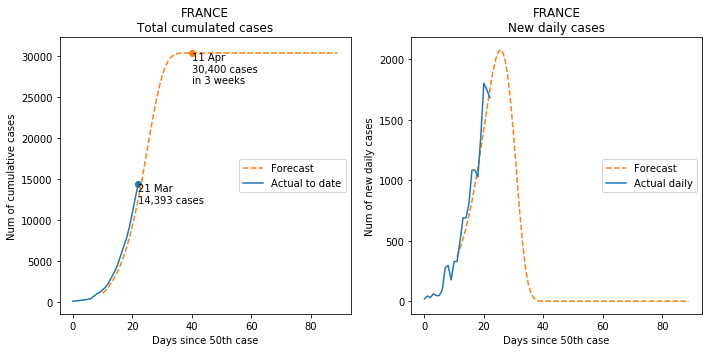

France A=30335, K=-3360, C=1.0005, Q=0.0004, B=-0.1821, v=0.0065


In [24]:
predict_plot('France', days=80, fit_start='20200309')

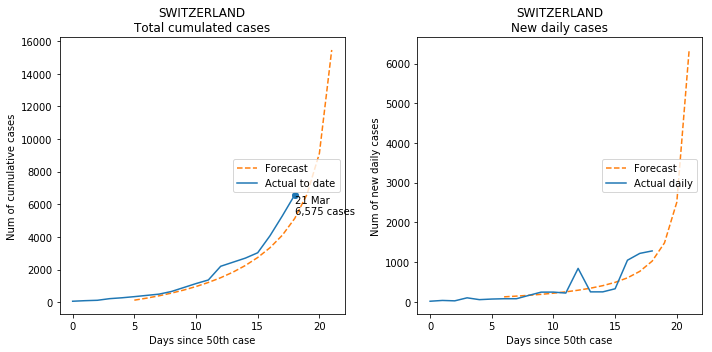

Switzerland A=-779, K=364, C=-0.0189, Q=1.6696, B=0.2685, v=2.0963


In [25]:
predict_plot('Switzerland', days=100, fit_start='20200308', showpeak=False)

In [26]:
## # Generalised logistic function (Richard's curve)
# def richards(x, A, K, C, Q, B, v):
#     y = A + (K-A) / ((C + (Q * np.exp(-1 * B * x))) ** (1/v))
#     return y

# # Fit to Richard's curve model
# def fit_richards(country, rolling=1, fit_start=None, fit_end=None, days=110, df2=df2):

#     # All dates in raw Actuals
#     dates = df2.loc[df2.country==country].reset_index(drop=True).date
#     # All raw Actuals
#     actual0 = df2.loc[df2.country==country, 'confirmed'].reset_index(drop=True)

#     # Limit Actual data period for model fit
#     oneday = pd.Timedelta(1, unit='days')
#     fit_start   = pd.to_datetime(fit_start, format='%Y%m%d')
#     fit_end     = pd.to_datetime(fit_end, format='%Y%m%d')
#     index_start = list(dates[dates==fit_start].index)[0] if fit_start != None else None
#     index_end   = list(dates[dates==fit_end+oneday].index)[0] if fit_end != None else None
#     actual1 = actual0.iloc[index_start:index_end]

#     # Data for model fit input after rolling average
#     dropna = range(actual1.index.min(),actual1.index.min()+(rolling-1))
#     actual2 = actual1.rolling(window=rolling).mean().drop(dropna) if rolling > 1 else actual1
#     xdata = np.array(range(rolling,len(actual2)+rolling))
#     ydata = np.array(actual2.values)

#     # Fit model
#     popt, pcov = curve_fit(richards, xdata, ydata, maxfev=3000)
#     A, K, C, Q, B, v = popt

#     xdata2 = np.array(range(days))
#     #index = range(days)
#     index = range(actual1.index.min(), days+actual2.index.min())
#     #index = range(1, days+1) if rolling > 1 else range(days)
#     predict = pd.DataFrame(richards(xdata2, A, K, C, Q, B, v), columns=['predict'], index=index)
#     predict = predict.iloc[:,0]
    
#     return dates, actual0, actual2, predict

# # Fit to curve and plot prediction
# def predict_plot(country, rolling=1, fit_start=None, fit_end=None, days=110, showzero=True, df2=df2):

#     dates, actual0, actual2, predict = fit_richards(country, rolling, fit_start, fit_end, days, df2)
        
#     # Find dates for plot labels
#     # Latest available date in raw Actual
#     latestdate = dates.iloc[-1]
#     # Calculate difference between predicted days to find plateau
#     predict = predict if predict.isna().sum() > 0 else predict.astype('int')
#     newcase0 = predict.diff().drop(predict.index.min())
#     newcase1 = newcase0.iloc[actual2.index.max():] # exclude if zero happens during Actual period
#     # If prediction doesn't coverge to plateau, don't show
#     if np.isnan(newcase1[newcase1==0].index.min()):
#         showzero = False
#     # If prediction converges to plateau:
#     else:
#         # Day when difference between days equal to zero
#         zerocase = newcase1[newcase1==0].index.min()
#         to_go_weeks = int(round((zerocase-len(actual2))/7))
#         oneday = pd.Timedelta(1, unit='days')
#         zerodate = latestdate + oneday * to_go_weeks * 7
                
#     fig, ax = plt.subplots()
#     mdict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    
#     # Plot prediction
#     plt.plot(predict, ls='dashed', c='#ff7f0e', label='Forecast')
    
#     # Plot actual
#     plt.plot(actual0, c='#1f77b4', label='Actual to date')
#     plt.scatter(actual0.index[-1], int(actual0.iloc[-1]), c='#1f77b4')
#     plt.text(actual0.index[-1], actual0.iloc[-1], f'{latestdate.day} {mdict[latestdate.month]}\n{format(int(actual0.iloc[-1]), ",")} cases', va='top')
   
#     # Plot actual moving average
#     if rolling > 1:
#         plt.plot(actual2, ls=':', label=f'Act {rolling}-day moving avg')

#     # Plot prediction end points
#     if showzero==True:
#         plt.scatter(zerocase, predict.max(), c='#ff7f0e')      
#         predictmax = int(math.ceil(predict.max()/100.0))*100 if predict.max() > actual2.iloc[-1] else int(math.ceil(actual0.iloc[-1]/100.0))*100
#         plt.text(zerocase, predictmax, f'{zerodate.day} {mdict[zerodate.month]}\n{format(predictmax, ",")} cases\nin {to_go_weeks} weeks', va='top')
    
#     # Plot titles and axis
#     ax.set_title(country)
#     ax.set_ylabel('Num of cumulative cases')
#     ax.set_xlabel('Days since 50th case')
#     plt.legend(loc='lower right')
#     plt.show()